In [1]:
codigo_canhero = 6401

In [2]:
from werkzeug.wrappers import Request, Response
from jinja2 import Template
from datetime import datetime, timedelta
import collections
from datetime import datetime

from amigocloud import AmigoCloud

<frozen importlib._bootstrap>:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject


In [3]:
acceso = open('../api_key/api.key','r')
api_token = acceso.readlines()[0]
acceso.close()

amigocloud = AmigoCloud(token=api_token)
amigocloud

In [4]:
# DATOS DE LAS INPECCION
query = {'query': 'select CURRENT_DATE, * from dataset_292618 where cast(split_part(canhero, \' / \', 1) as integer) = {cod_ca}'.format(cod_ca=codigo_canhero)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
data = select['data'][0]
data['date'] = datetime.strptime(data['date'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_quema'] = datetime.strptime(data['fecha_quema'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_inspeccion'] = datetime.strptime(data['fecha_inspeccion'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')

insp = collections.namedtuple("insp", data.keys())(*data.values())
print('end')

end


In [5]:
insp

insp(date='31/05/2022', fecha_registro='2022-05-30 17:24:22+00:00', amigo_id='984a1c56dca24e9eaa109114ca1cd100', fecha_quema='14/05/2022', fecha_inspeccion='19/05/2022', fecha_update='2022-05-31 14:32:44.588200+00:00', canhero='6401 / JALDIN SOTO BRIGIDA', superficie_total=6.09, rendimiento=35.0, produccion=213.15, responsable='Rogelio Acuña Rodríguez', inicio_incendio='Fuera de la propiedad', causa='Quema de malojo', responsable_de_quema='RICHARD ESPINOZA', observaciones='Quema de malojo en la propiedad vecina', link_informe=None, link_informe_editable=None, cite=243)

In [6]:
# DATOS DE LA PROPIEDAD
query = {'query': 'select * from dataset_293179 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=insp.amigo_id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
propiedades_data = select['data']
print('end')

end


In [7]:
propiedades_data

[{'ubicacion': '0101000020E61000006842BAAE9D914FC010360CF4222D31C0',
  'amigo_id': 'f542146f4f824dbfa16c5c577bd21d66',
  'fecha_registro': '2022-05-30 17:25:23+00:00',
  'fecha_update': '2022-05-30 17:25:23+00:00',
  'propiedad': '1755 / SANTA TEREZA--JALDIN BRIGIDA',
  'tenencia': 'Propio',
  'insp_ref_prop': '984a1c56dca24e9eaa109114ca1cd100'}]

In [8]:
propiedades = []
for prop in propiedades_data:
    prop['lote'] = []
    query_lotes = {'query': 'select * from dataset_293180 where prop_ref_lote = \'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    lotes_select = amigocloud.get(project, query_lotes)
    for lote_select in lotes_select['data']:
        lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
        prop['lote'].append(lote)
    propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
print('end')

end


In [9]:
propiedades

[propiedad(ubicacion='0101000020E61000006842BAAE9D914FC010360CF4222D31C0', amigo_id='f542146f4f824dbfa16c5c577bd21d66', fecha_registro='2022-05-30 17:25:23+00:00', fecha_update='2022-05-30 17:25:23+00:00', propiedad='1755 / SANTA TEREZA--JALDIN BRIGIDA', tenencia='Propio', insp_ref_prop='984a1c56dca24e9eaa109114ca1cd100', lote=[lote(geometria='0106000020E6100000010000000103000000010000000B0000008C971890C7914FC0828DB0B2E72C31C0E41F8CDB7C914FC03F211CC1E12C31C07ED86C9170914FC02945B8C0412D31C073C528574C914FC098A86D8B402D31C09309148A48914FC052697326432D31C0E463421045914FC0A69E4E824A2D31C049B49E3543914FC0197805E85A2D31C0F395B1AABF914FC0A9AF431B662D31C082CCE79CC3914FC038EDA536262D31C07483AF08C6914FC0F43BA7B5FC2C31C08C971890C7914FC0828DB0B2E72C31C0', amigo_id='8bae916cdbc64ec48b7f5b155898dd90', fecha_registro='2022-05-30 17:08:17+00:00', fecha_update='2022-05-30 17:38:58.552173+00:00', lote='L1', superficie=6.09, observaciones=None, prop_ref_lote='f542146f4f824dbfa16c5c577bd21d66')])]

In [10]:
# fotos lotes
fotos = []
for propiedad in propiedades:
    for lote in propiedad.lote:
        print(lote.lote, lote.amigo_id)
        query_fotos = {'query': 'select source_amigo_id, s3_filename from gallery_42303 where source_amigo_id=\'{source_amigo_id}\''.format(source_amigo_id=lote.amigo_id)}
        project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
        fotos_filename = amigocloud.get(project, query_fotos)
        if fotos_filename['data'] != []:
            dic = {'lote': lote.lote, 'file_name': fotos_filename['data'][0]['s3_filename']}
            fotos.append(dic)

fotos

L1 8bae916cdbc64ec48b7f5b155898dd90


[{'lote': 'L1', 'file_name': 'QUEMA_SEÑORA_JALDIN.jpeg'}]

In [11]:
from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)[0]

end


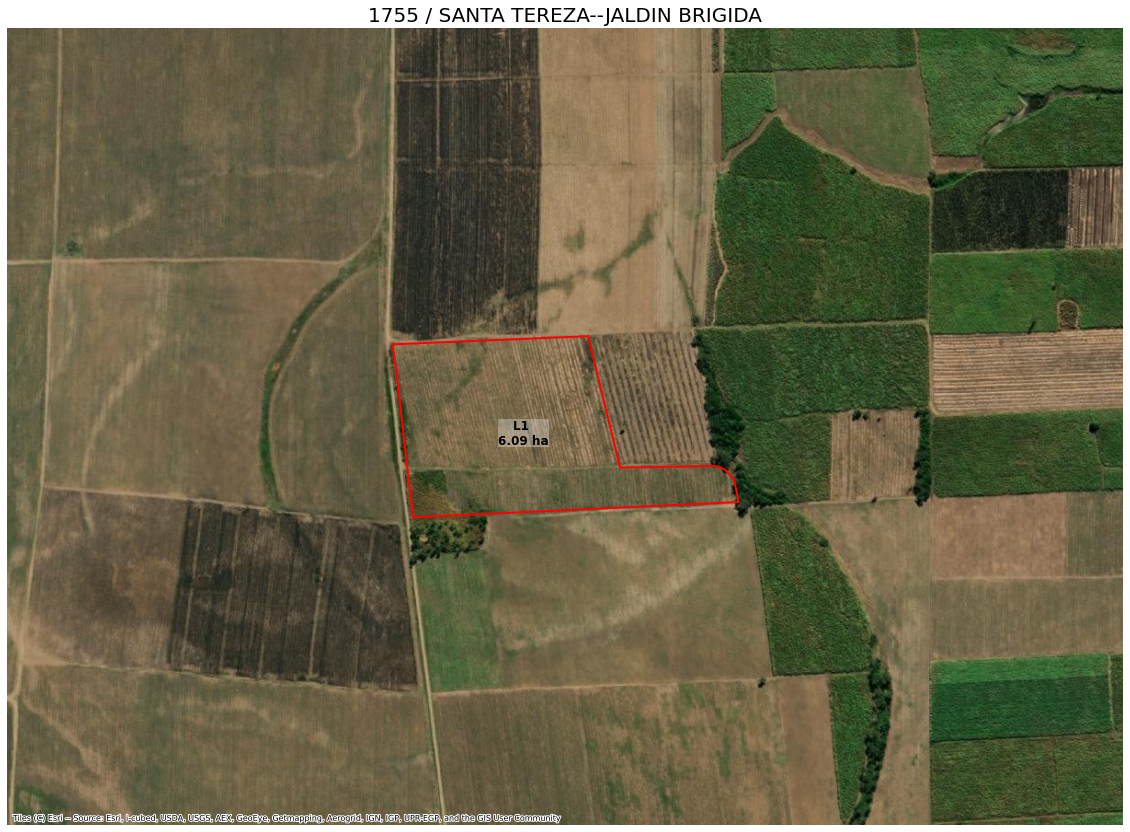

In [12]:
i = 0
lista_planos = []
ruta = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lote:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    ruta = 'planos/' + str(insp.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
    lista_planos.append(ruta)
    fig.savefig(ruta, dpi = 300, bbox_inches='tight')
    del fig
print('end')

In [14]:
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

doc = DocxTemplate("templates/template_01.docx")

#generar lista de InlineImage de planos 
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    file = open('fotos/' + foto['file_name'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor='fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})

firma_respon = None
if insp.responsable == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor='templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor='templates/firma_jaldin.png', width=Mm(60))

context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)

# formato de nombre de archivo: "123_CQ_01-01-2022_NOMBRE"
cod_nom = insp.canhero.split(' / ')
file_name = cod_nom[0] + '_CQ_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1]

doc.save('_' + file_name + '.docx')